In [ ]:
#Challenge 1


In [2]:
import pandas as pd
import sqlite3
import numpy as np
from datetime import datetime, timedelta

def generate_sample_news(n=10, start_date=None):
    if start_date is None:
        start_date = datetime.now()

    companies = ['Apple', 'Netflix', 'Walmart', 'Nvidia', 'Google']
    sentiments = ['positive', 'negative', 'neutral']

    data = {
        'timestamp': [start_date + timedelta(hours=i) for i in range(n)],
        'company': np.random.choice(companies, n),
        'headline': [f'News headline {i}' for i in range(n)],
        'sentiment': np.random.choice(sentiments, n),
        'sentiment_score': np.random.uniform(-1, 1, n)
    }

    return pd.DataFrame(data)
df_batch1 = generate_sample_news(10)
print("First batch of news:")
print(df_batch1.head())
print(f"\nData types:\n{df_batch1.dtypes}")


First batch of news:
                   timestamp  company         headline sentiment  \
0 2026-01-07 11:19:54.445859   Google  News headline 0   neutral   
1 2026-01-07 12:19:54.445859   Google  News headline 1  negative   
2 2026-01-07 13:19:54.445859  Netflix  News headline 2   neutral   
3 2026-01-07 14:19:54.445859   Nvidia  News headline 3   neutral   
4 2026-01-07 15:19:54.445859  Netflix  News headline 4   neutral   

   sentiment_score  
0         0.407363  
1        -0.041773  
2         0.651029  
3         0.385586  
4         0.783394  

Data types:
timestamp          datetime64[ns]
company                    object
headline                   object
sentiment                  object
sentiment_score           float64
dtype: object


In [3]:
db_path = 'news.db'
conn = sqlite3.connect(db_path)
df_batch1.to_sql('news_data', conn, if_exists='replace', index=False)

conn.close()
print(f"✅ Saved {len(df_batch1)} records to {db_path}")

✅ Saved 10 records to news.db


In [4]:
df_batch2 = generate_sample_news(10, start_date=datetime.now() + timedelta(days=1))
conn = sqlite3.connect(db_path)
df_batch2.to_sql('news_data', conn, if_exists='append', index=False)
conn.close()

print(f"✅ Appended {len(df_batch2)} more records")

✅ Appended 10 more records


In [5]:
conn = sqlite3.connect(db_path)
df_from_db = pd.read_sql_query("SELECT * FROM news_data", conn)
conn.close()

print(f"Total records in database: {len(df_from_db)}")
print(f"\nData types preserved:\n{df_from_db.dtypes}")
print(f"\nFirst few rows:\n{df_from_db.head()}")
print(f"\nLast few rows:\n{df_from_db.tail()}")

Total records in database: 20

Data types preserved:
timestamp           object
company             object
headline            object
sentiment           object
sentiment_score    float64
dtype: object

First few rows:
                    timestamp  company         headline sentiment  \
0  2026-01-07 11:19:54.445859   Google  News headline 0   neutral   
1  2026-01-07 12:19:54.445859   Google  News headline 1  negative   
2  2026-01-07 13:19:54.445859  Netflix  News headline 2   neutral   
3  2026-01-07 14:19:54.445859   Nvidia  News headline 3   neutral   
4  2026-01-07 15:19:54.445859  Netflix  News headline 4   neutral   

   sentiment_score  
0         0.407363  
1        -0.041773  
2         0.651029  
3         0.385586  
4         0.783394  

Last few rows:
                     timestamp  company         headline sentiment  \
15  2026-01-08 16:21:00.926970   Google  News headline 5  positive   
16  2026-01-08 17:21:00.926970  Walmart  News headline 6   neutral   
17  2026-01-08

In [6]:

conn = sqlite3.connect(db_path)

# for only  Apple news
apple_news = pd.read_sql_query("""
    SELECT * FROM news_data
    WHERE company = 'Apple'
    ORDER BY timestamp DESC
""", conn)

print(f"Apple news count: {len(apple_news)}")
print(apple_news)


avg_sentiment = pd.read_sql_query("""
    SELECT company, AVG(sentiment_score) as avg_score
    FROM news_data
    GROUP BY company
    ORDER BY avg_score DESC
""", conn)

print(f"\nAverage sentiment by company:\n{avg_sentiment}")

conn.close()

Apple news count: 4
                    timestamp company         headline sentiment  \
0  2026-01-08 20:21:00.926970   Apple  News headline 9  negative   
1  2026-01-08 13:21:00.926970   Apple  News headline 2  negative   
2  2026-01-08 12:21:00.926970   Apple  News headline 1  negative   
3  2026-01-07 17:19:54.445859   Apple  News headline 6  positive   

   sentiment_score  
0        -0.820610  
1         0.219828  
2        -0.428385  
3        -0.797683  

Average sentiment by company:
   company  avg_score
0  Netflix   0.637207
1   Google   0.248801
2  Walmart   0.168856
3   Nvidia  -0.163859
4    Apple  -0.456712


In [7]:


import pyarrow as pa
import pyarrow.parquet as pq
import os

# Save first batch to Parquet
parquet_file = 'news.parquet'
df_batch1.to_parquet(parquet_file, engine='pyarrow', index=False)

print(f"✅ Saved {len(df_batch1)} records to {parquet_file}")

✅ Saved 10 records to news.parquet


In [8]:
# Adding to Parquet (requires reading, concatenating, and writing permissions)
if os.path.exists(parquet_file):
    existing_df = pd.read_parquet(parquet_file)
    combined_df = pd.concat([existing_df, df_batch2], ignore_index=True)
else:
    combined_df = df_batch2

combined_df.to_parquet(parquet_file, engine='pyarrow', index=False)
print(f"✅ Appended data. Total records: {len(combined_df)}")


✅ Appended data. Total records: 20


In [9]:
df_from_parquet = pd.read_parquet(parquet_file)

print(f"Total records: {len(df_from_parquet)}")
print(f"\nData types preserved:\n{df_from_parquet.dtypes}")
print(f"\nFirst few rows:\n{df_from_parquet.head()}")


Total records: 20

Data types preserved:
timestamp          datetime64[ns]
company                    object
headline                   object
sentiment                  object
sentiment_score           float64
dtype: object

First few rows:
                   timestamp  company         headline sentiment  \
0 2026-01-07 11:19:54.445859   Google  News headline 0   neutral   
1 2026-01-07 12:19:54.445859   Google  News headline 1  negative   
2 2026-01-07 13:19:54.445859  Netflix  News headline 2   neutral   
3 2026-01-07 14:19:54.445859   Nvidia  News headline 3   neutral   
4 2026-01-07 15:19:54.445859  Netflix  News headline 4   neutral   

   sentiment_score  
0         0.407363  
1        -0.041773  
2         0.651029  
3         0.385586  
4         0.783394  


In [10]:
import os
#comparing the spaces
csv_file = 'news.csv'
combined_df.to_csv(csv_file, index=False)

csv_size = os.path.getsize(csv_file) / 1024  # KB
parquet_size = os.path.getsize(parquet_file) / 1024  # KB
db_size = os.path.getsize(db_path) / 1024  # KB

print(f"File size comparison:")
print(f"CSV: {csv_size:.2f} KB")
print(f"Parquet: {parquet_size:.2f} KB")
print(f"SQLite: {db_size:.2f} KB")

File size comparison:
CSV: 1.59 KB
Parquet: 3.77 KB
SQLite: 8.00 KB


In [ ]:
#Challenge 3

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import yfinance as yf

# getting real stock data
print("Fetching Apple stock data...")
df = yf.download('TSLA', start='2024-01-01', end='2025-12-31', progress=False)

print(f"✅ Downloaded {len(df)} days of data")
print(df.head())

Fetching Apple stock data...


/tmp/ipython-input-3861561276.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('TSLA', start='2024-01-01', end='2025-12-31', progress=False)


✅ Downloaded 501 days of data
Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2024-01-02  248.419998  251.250000  244.410004  250.080002  104654200
2024-01-03  238.449997  245.679993  236.320007  244.979996  121082600
2024-01-04  237.929993  242.699997  237.729996  239.250000  102629300
2024-01-05  237.490005  240.119995  234.899994  236.860001   92488900
2024-01-08  240.449997  241.250000  235.300003  236.139999   85166600


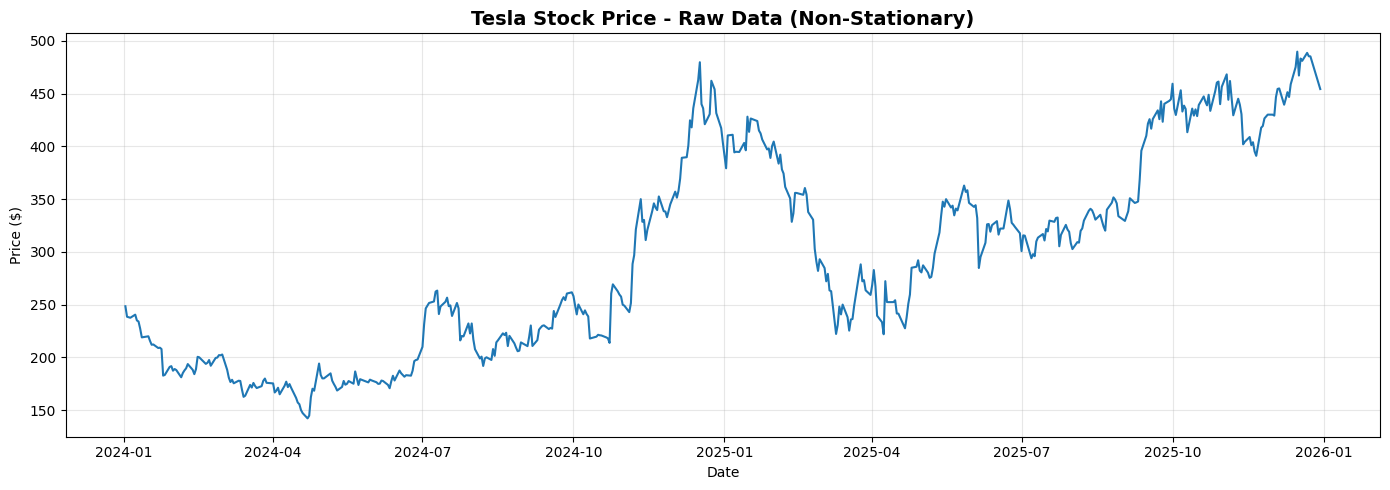

In [12]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Close'])
plt.title('Tesla Stock Price - Raw Data (Non-Stationary)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
def perform_adf_test(series, name='Series'):
    """
    Perform Augmented Dickey-Fuller test and print results.
    """
    result = adfuller(series.dropna())

    print(f"\n{'='*60}")
    print(f"ADF Test Results for: {name}")
    print(f"{'='*60}")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"P-value: {result[1]:.6f}")
    print(f"Number of lags used: {result[2]}")
    print(f"Number of observations: {result[3]}")
    print(f"\nCritical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")

    print(f"\n{'='*60}")
    if result[1] < 0.05:
        print(f"✅ PASS: p-value < 0.05 → Data is STATIONARY")
    else:
        print(f"❌ FAIL: p-value > 0.05 → Data is NON-STATIONARY")
        print(f"   ⚠️  You cannot train an LSTM on this data!")
    print(f"{'='*60}\n")

    return result[1]  # Return p-value

# Test raw prices
p_value_raw = perform_adf_test(df['Close'], 'Raw Close Prices')


ADF Test Results for: Raw Close Prices
ADF Statistic: -0.874717
P-value: 0.796184
Number of lags used: 0
Number of observations: 500

Critical Values:
  1%: -3.443
  5%: -2.867
  10%: -2.570

❌ FAIL: p-value > 0.05 → Data is NON-STATIONARY
   ⚠️  You cannot train an LSTM on this data!



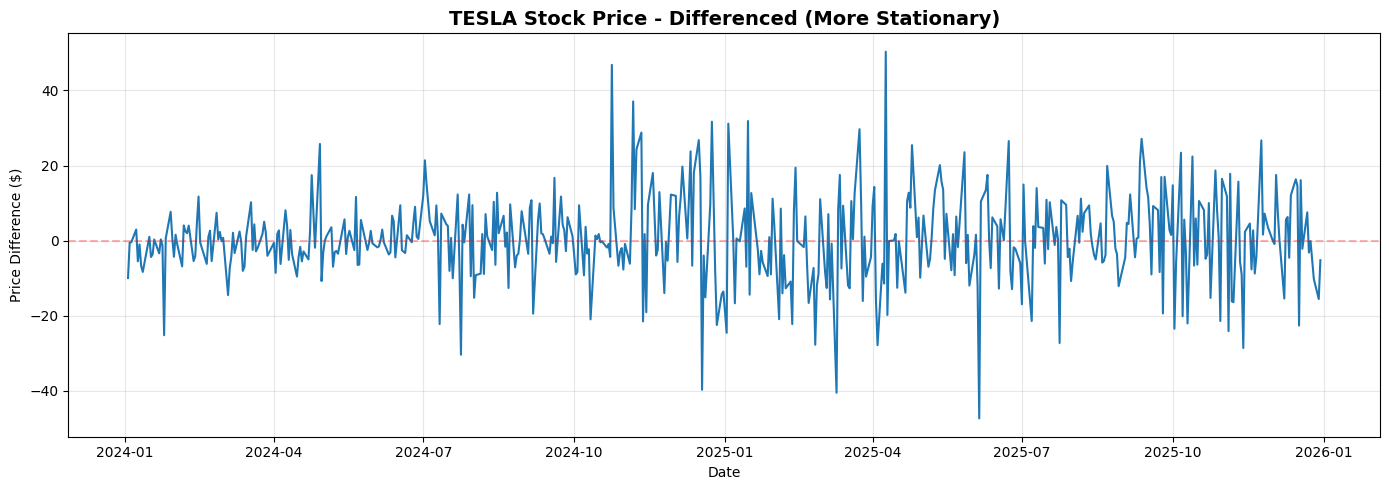

Notice: No clear trend, oscillates around 0!

ADF Test Results for: Differenced Prices
ADF Statistic: -23.040045
P-value: 0.000000
Number of lags used: 0
Number of observations: 499

Critical Values:
  1%: -3.444
  5%: -2.867
  10%: -2.570

✅ PASS: p-value < 0.05 → Data is STATIONARY



In [14]:
df['Price_Diff'] = df['Close'].diff()

# Plot differenced data
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Price_Diff'])
plt.title('TESLA Stock Price - Differenced (More Stationary)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price Difference ($)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice: No clear trend, oscillates around 0!")

# Test differenced data
# Ensure the series is not empty after dropping NaNs before passing to adfuller
differenced_series = df['Price_Diff'].dropna()
if differenced_series.empty:
    print("Error: Differenced series is empty after dropping NaNs. Cannot perform ADF test.")
    p_value_diff = None
else:
    p_value_diff = perform_adf_test(differenced_series, 'Differenced Prices')

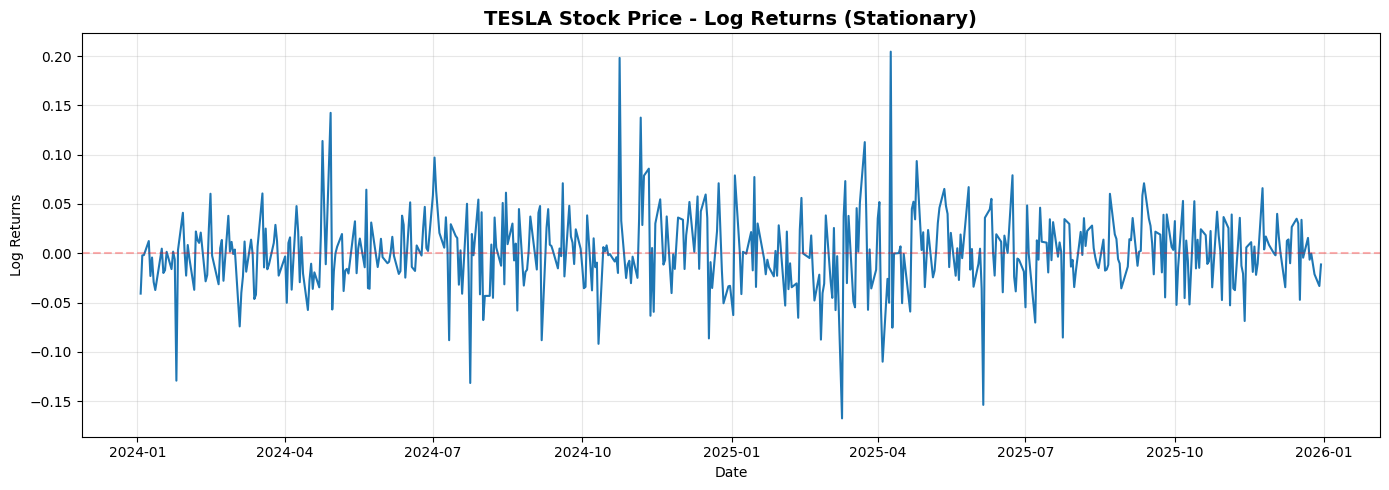

Notice: No clear trend, oscillates around 0!

ADF Test Results for: Log Returns
ADF Statistic: -22.714206
P-value: 0.000000
Number of lags used: 0
Number of observations: 499

Critical Values:
  1%: -3.444
  5%: -2.867
  10%: -2.570

✅ PASS: p-value < 0.05 → Data is STATIONARY



In [15]:
# Calculate log returns
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Plot log returns
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Log_Returns'])
plt.title('TESLA Stock Price - Log Returns (Stationary)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice: No clear trend, oscillates around 0!")

log_series = df['Log_Returns'].dropna()

if log_series.empty:
    print("Error: Log series is empty after dropping NaNs. Cannot perform ADF test.")
    p_value_log = None
else:

    p_value_log = perform_adf_test(log_series, 'Log Returns')

In [17]:
#REPORT
results_df = pd.DataFrame({
    'Method': ['Raw Prices', 'Differencing', 'Log Returns'],
    'P-Value': [p_value_raw, p_value_diff, p_value_log],
    'Stationary': [p_value_raw < 0.05, p_value_diff < 0.05, p_value_log < 0.05]
})

results_df['Status'] = results_df['Stationary'].apply(lambda x: '✅ PASS' if x else '❌ FAIL')

print("\n" + "="*60)
print("SUMMARY: Stationarity Test Results")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)


SUMMARY: Stationarity Test Results
      Method  P-Value  Stationary Status
  Raw Prices 0.796184       False ❌ FAIL
Differencing 0.000000        True ✅ PASS
 Log Returns 0.000000        True ✅ PASS


In [ ]:
#Challenge 2

In [18]:
import spacy
import pandas as pd


nlp = spacy.load('en_core_web_sm')
print("✅ spaCy model loaded successfully")

✅ spaCy model loaded successfully


In [19]:
sample_texts = [
  "Microsoft announces major layoffs in 2026",

   "The windows in my house need replacement",

"Google launches a new AI-powered search feature",

"I searched the answer on google last night",

"Meta invests heavily in virtual reality research",

"The meaning of the word meta is beyond or abstract"
]

print("Entity Detection Examples:")
print("=" * 60)

for text in sample_texts:
    doc = nlp(text)
    print(f"\nText: {text}")
    if doc.ents:
        for ent in doc.ents:
            print(f"  - '{ent.text}' → {ent.label_}")
    else:
        print("  - No entities found")


Entity Detection Examples:

Text: Microsoft announces major layoffs in 2026
  - 'Microsoft' → ORG
  - '2026' → DATE

Text: The windows in my house need replacement
  - No entities found

Text: Google launches a new AI-powered search feature
  - 'Google' → ORG
  - 'AI' → GPE

Text: I searched the answer on google last night
  - 'last night' → TIME

Text: Meta invests heavily in virtual reality research
  - No entities found

Text: The meaning of the word meta is beyond or abstract
  - No entities found


In [20]:
def check_entity_is_org(text, company_name):
    """
    Check if the company_name in the text is classified as an ORG.
    """
    doc = nlp(text)

    for ent in doc.ents:
        # Check if entity text contains company name (case-insensitive)
        if company_name.lower() in ent.text.lower():
            if ent.label_ == 'ORG':
                return True
            else:
                return False  # Found but not an ORG (e.g., a Location)

    return False  # Company name not found as an entity at all

# Test the function
test_cases = [
    ("Apple Inc. releases new iPhone", "Apple", True),
    ("I ate an apple for lunch", "Apple", False),
    ("Amazon expands its e-commerce platform", "Amazon", True),
    ("The Amazon river is the longest", "Amazon", False),
]

print("Testing NER Filter:")
print("=" * 60)
for text, company, expected in test_cases:
    result = check_entity_is_org(text, company)
    status = "✅" if result == expected else "❌"
    print(f"{status} '{text}' → {result} (expected {expected})")

Testing NER Filter:
✅ 'Apple Inc. releases new iPhone' → True (expected True)
✅ 'I ate an apple for lunch' → False (expected False)
✅ 'Amazon expands its e-commerce platform' → True (expected True)
❌ 'The Amazon river is the longest' → True (expected False)


In [21]:
news_data = {
    'headline': [
        'Apple announces new product line',
        'How to make apple pie at home',
        'Amazon stock surges on earnings beat',
        'Amazon rainforest conservation efforts',
        'Tesla unveils new electric vehicle',
        'Visit the Tesla museum in Belgrade',
        'Microsoft launches AI initiative',
        'Google reports strong ad revenue',
        'Trip to New York and visiting Google offices',
        'Apple trees need proper care'
    ],
    'company': ['Apple', 'Apple', 'Amazon', 'Amazon', 'Tesla',
               'Tesla', 'Microsoft', 'Google', 'Google', 'Apple']
}

df = pd.DataFrame(news_data)

# Apply NER filter
df['is_org'] = df.apply(
    lambda row: check_entity_is_org(row['headline'], row['company']),
    axis=1
)

# Filter to keep only ORG entities
df_filtered = df[df['is_org'] == True].copy()

print(f"Filtered dataset: {len(df_filtered)} articles (removed {len(df) - len(df_filtered)} non-ORG)")
print("\nCleaned News for Analysis:")
print(df_filtered[['headline', 'company']])

Filtered dataset: 7 articles (removed 3 non-ORG)

Cleaned News for Analysis:
                                       headline    company
0              Apple announces new product line      Apple
2          Amazon stock surges on earnings beat     Amazon
3        Amazon rainforest conservation efforts     Amazon
6              Microsoft launches AI initiative  Microsoft
7              Google reports strong ad revenue     Google
8  Trip to New York and visiting Google offices     Google
9                  Apple trees need proper care      Apple


In [22]:
def check_entity_is_org_refined(text, company_name):
    """
    Enhanced filter that uses both NER and keyword exclusion
    to remove non-business news.
    """
    # 1. Define 'Noise' keywords that don't belong in stock news
    noise_keywords = ['rainforest', 'river', 'tree', 'fruit', 'pie', 'recipe', 'care']

    # 2. Pre-filter: if any noise word exists, reject immediately
    if any(word in text.lower() for word in noise_keywords):
        return False

    doc = nlp(text)

    # 3. Standard NER check
    for ent in doc.ents:
        if company_name.lower() in ent.text.lower():
            # Only keep if strictly identified as an Organization
            return ent.label_ == 'ORG'

    return False

# Re-apply the refined filter to your DataFrame
df['is_org_refined'] = df.apply(
    lambda row: check_entity_is_org_refined(row['headline'], row['company']),
    axis=1
)

# Show the results
df_final = df[df['is_org_refined'] == True].copy()
print(f"✅ Final Cleaned Dataset: {len(df_final)} articles")
print(df_final[['headline', 'company']])

✅ Final Cleaned Dataset: 5 articles
                                       headline    company
0              Apple announces new product line      Apple
2          Amazon stock surges on earnings beat     Amazon
6              Microsoft launches AI initiative  Microsoft
7              Google reports strong ad revenue     Google
8  Trip to New York and visiting Google offices     Google


In [23]:
df['is_org'] = df.apply(
    lambda row: check_entity_is_org_refined(row['headline'], row['company']),
    axis=1
)

print("Dataset with NER check:")
print(df)

# Filter to keep only ORG entities
df_filtered = df[df['is_org'] == True].copy()

print(f"✅ Filtered dataset: {len(df_filtered)} articles (removed {len(df) - len(df_filtered)} non-ORG)")
print("Filtered articles:")
print(df_filtered[['headline', 'company']])
#using the refined ner filter

Dataset with NER check:
                                       headline    company  is_org  \
0              Apple announces new product line      Apple    True   
1                 How to make apple pie at home      Apple   False   
2          Amazon stock surges on earnings beat     Amazon    True   
3        Amazon rainforest conservation efforts     Amazon   False   
4            Tesla unveils new electric vehicle      Tesla   False   
5            Visit the Tesla museum in Belgrade      Tesla   False   
6              Microsoft launches AI initiative  Microsoft    True   
7              Google reports strong ad revenue     Google    True   
8  Trip to New York and visiting Google offices     Google    True   
9                  Apple trees need proper care      Apple   False   

   is_org_refined  
0            True  
1           False  
2            True  
3           False  
4           False  
5           False  
6            True  
7            True  
8            True  
9    

In [24]:
def filter_org_articles_batch(df, text_column='headline', company_column='company'):
    """
    Efficiently filter articles using spaCy's pipe with noise reduction.
    """
    results = []
    noise_keywords = ['rainforest', 'river', 'tree', 'fruit', 'pie', 'recipe', 'care']

    # Process in batches using nlp.pipe for high performance
    docs = nlp.pipe(df[text_column])

    for idx, doc in enumerate(docs):
        headline_text = df.iloc[idx][text_column].lower()
        company = df.iloc[idx][company_column].lower()
        is_org = False

        # 1. First, check for noise keywords
        if any(word in headline_text for word in noise_keywords):
            results.append(False)
            continue

        # 2. Then, check the entities detected by spaCy
        for ent in doc.ents:
            if company in ent.text.lower() and ent.label_ == 'ORG':
                is_org = True
                break

        results.append(is_org)

    return results

# Test with our dataset
df['is_org_batch'] = filter_org_articles_batch(df)

print("Batch processing results:")
print(df[['headline', 'company', 'is_org_batch']])

Batch processing results:
                                       headline    company  is_org_batch
0              Apple announces new product line      Apple          True
1                 How to make apple pie at home      Apple         False
2          Amazon stock surges on earnings beat     Amazon          True
3        Amazon rainforest conservation efforts     Amazon         False
4            Tesla unveils new electric vehicle      Tesla         False
5            Visit the Tesla museum in Belgrade      Tesla         False
6              Microsoft launches AI initiative  Microsoft          True
7              Google reports strong ad revenue     Google          True
8  Trip to New York and visiting Google offices     Google          True
9                  Apple trees need proper care      Apple         False


In [ ]:
#Challenge 4

In [25]:

#making it for indian standards time zone
import pandas as pd
import numpy as np
from datetime import datetime, time
import pytz

# Define IST timezone and Indian Market Hours
IST = pytz.timezone('Asia/Kolkata')
# Aligning news to 15:30:00 IST.
MARKET_CLOSE = time(15, 30)

In [26]:
news_data = {
    'headline': ['Apple Product', 'Tesla Earnings', 'Amazon Cloud', 'Microsoft AI', 'Google Quarter', 'Weekend Apple', 'Sat Tesla'],
    'timestamp_utc': [
        '2024-01-15 08:00:00', '2024-01-15 06:00:00', '2024-01-15 14:00:00',
        '2024-01-15 18:30:00', '2024-01-16 01:00:00', '2024-01-20 10:00:00', '2024-01-21 12:00:00'
    ],
    'sentiment_score': [0.8, 0.6, 0.7, 0.5, 0.9, 0.4, 0.3]
}

df_news = pd.DataFrame(news_data)
df_news['timestamp_utc'] = pd.to_datetime(df_news['timestamp_utc']).dt.tz_localize('UTC')
print("Input UTC Data Ready.")

Input UTC Data Ready.


In [27]:
def map_to_trading_day(ts):
    # Rule 1: Weekend → Monday
    if ts.weekday() >= 5:
        return (ts + pd.Timedelta(days=7 - ts.weekday())).replace(hour=0, minute=0, second=0, microsecond=0).tz_localize(None)

    # Rule 2: After Market Close → Next Business Day
    if ts.time() > MARKET_CLOSE:
        return (ts + pd.tseries.offsets.BusinessDay(1)).replace(hour=0, minute=0, second=0, microsecond=0).tz_localize(None)

    # Rule 3: During/Before Market → Today
    return pd.Timestamp(ts.date())

# Convert to IST and Apply Logic
df_news['timestamp_ist'] = df_news['timestamp_utc'].dt.tz_convert(IST)
df_news['trading_day'] = df_news['timestamp_ist'].apply(map_to_trading_day)

# Final Clean: Ensure everything is a simple date (removes +05:30 and time)
df_news['trading_day'] = pd.to_datetime(df_news['trading_day']).dt.normalize()

print(df_news[['headline', 'timestamp_ist', 'trading_day']])

         headline             timestamp_ist trading_day
0   Apple Product 2024-01-15 13:30:00+05:30  2024-01-15
1  Tesla Earnings 2024-01-15 11:30:00+05:30  2024-01-15
2    Amazon Cloud 2024-01-15 19:30:00+05:30  2024-01-16
3    Microsoft AI 2024-01-16 00:00:00+05:30  2024-01-16
4  Google Quarter 2024-01-16 06:30:00+05:30  2024-01-16
5   Weekend Apple 2024-01-20 15:30:00+05:30  2024-01-22
6       Sat Tesla 2024-01-21 17:30:00+05:30  2024-01-22


In [28]:
#Monday to friday
trading_dates = pd.date_range(start='2024-01-15', end='2024-01-25', freq='B')
df_stock = pd.DataFrame({'date': trading_dates, 'close': np.random.uniform(150, 160, len(trading_dates))})

# 2. Aggregate News
# Calculate the mean sentiment and count of articles per trading day
news_agg = df_news.groupby('trading_day').agg({'sentiment_score': ['mean', 'count']}).reset_index()
news_agg.columns = ['date', 'avg_sentiment', 'news_count']

# 3. Merge and Fill Zeros for days without news
df_merged = pd.merge(df_stock, news_agg, on='date', how='left').fillna(0)

print(df_merged.head(10))


        date       close  avg_sentiment  news_count
0 2024-01-15  150.238170           0.70         2.0
1 2024-01-16  151.706644           0.70         3.0
2 2024-01-17  157.780877           0.00         0.0
3 2024-01-18  154.817343           0.00         0.0
4 2024-01-19  154.106806           0.00         0.0
5 2024-01-22  150.317395           0.35         2.0
6 2024-01-23  151.228243           0.00         0.0
7 2024-01-24  159.035419           0.00         0.0
8 2024-01-25  156.891725           0.00         0.0
